<a href="https://colab.research.google.com/github/Intraraksa/restructure_meta_human/blob/master/asr/project_asr2onnx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Asr project 
This is the Botnoi project for chang asr (auto speech recognition to onnx)
ในโปรเจคนี้เป็นการแปลง Pretrain model wav2vec โมเดลที่ถูกเทรนของ Botnoi เพื่อแปลงเป็น Onnx Model เนื่องจากต้องการให้ Model มีขนาดที่เล็กลง

1. ใน section แรกจะเป็นการแปลง huggingface pytorch model เป็น onnx 
2. เป็นการ inference model

## Convert model

### install dependencies and import dependencies

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 34.5 MB/s 
     |████████████████████████████████| 84 kB 3.0 MB/s 
     |████████████████████████████████| 6.6 MB 19.5 MB/s 
     |████████████████████████████████| 596 kB 27.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Import dependenciies ที่จะใช้งานในขั้นตอนการแปลงไฟล์ โดย model ที่ pretrain ไว้จะอยู่ใน Folder ซึ่งจะรวมอยู่กับ utility ต่างๆ ดังนี้ (ในโปรเจคนี้จะเก็บใน Google Drive)

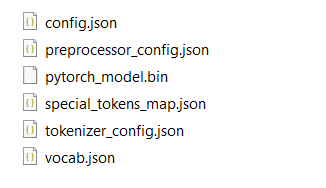

In [ ]:
import transformers
from transformers import AutoTokenizer, Wav2Vec2ForCTC
from torchaudio.models.wav2vec2.utils import import_huggingface_model
import torch.onnx

### load pytorch model

In [ ]:
## โหลด Pretrained model 
original = Wav2Vec2ForCTC.from_pretrained('/content/drive/MyDrive/last-20220125_224500')
## สร้าง Model pytorch ที่ inference เสียงพูด
model = import_huggingface_model(original)

In [ ]:
print(type(original))
print(type(model))

<class 'transformers.models.wav2vec2.modeling_wav2vec2.Wav2Vec2ForCTC'>
<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


### convert model
ขั้นตอนการแปลงเป็น ONNX 
โดยในขั้นตอนการแปลงไฟล์เป็น ONNX จาก Pytorch 
มีข้อจำกัดคือ ต้องมีการกำหนด dummy input ซึ่งมีการ fix size ตายตัว

In [ ]:
input_size = 100000
AUDIO_MAXLEN = input_size

dummy_input = torch.randn(1, input_size, requires_grad=True)

In [ ]:
torch.onnx.export(model,         # model being run
         dummy_input,       # model input (or a tuple for multiple inputs)
         "/content/drive/MyDrive/last-20220125_224500/asr_botnoi11.onnx",       # where to save the model
         export_params=True,  # store the trained parameter weights inside the model file
         opset_version=10,    # the ONNX version to export the model to
         do_constant_folding=True,  # whether to execute constant folding for optimization
         input_names = ['modelInput'],   # the model's input names
         output_names = ['modelOutput'], # the model's output names
         dynamic_axes={'modelInput' : {0 : 'batch_size'},    # variable length axes
                                'modelOutput' : {0 : 'batch_size'}})

## inference model

In [ ]:
!pip install onnxruntime

     |████████████████████████████████| 5.2 MB 29.5 MB/s 


In [ ]:
!sudo apt-get install libportaudio2
!sudo apt-get install libasound-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 1s (81.5 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falli

In [ ]:
!pip install sounddevice pythainlp soundfile

     |████████████████████████████████| 11.5 MB 52.2 MB/s 


In [ ]:
import sounddevice as sd
import numpy as np
import onnxruntime as rt
import scipy.signal as sps
from datetime import datetime
from pythainlp.util import normalize

## inference onnx model

### create inference function

In [ ]:
input_size = 100000
new_rate = 16000
AUDIO_MAXLEN = input_size

ort_session = rt.InferenceSession('/content/drive/MyDrive/last-20220125_224500/asr_botnoi.onnx')

with open("/content/drive/MyDrive/last-20220125_224500/vocab.json","r",encoding="utf-8-sig") as f:
    d = eval(f.read())

res = dict((v,k) for k,v in d.items())
res[69]="[PAD]"
res[68]="[UNK]"

def _normalize(x): #
    """You must call this before padding.
  Code from https://github.com/vasudevgupta7/gsoc-wav2vec2/blob/main/src/wav2vec2/processor.py#L101
  Fork TF to numpy
  """
  # -> (1, seqlen)
    mean = np.mean(x, axis=-1, keepdims=True)
    var = np.var(x, axis=-1, keepdims=True)
    # return np.squeeze((x - mean) / np.sqrt(var + 1e-5))
    res  =  np.squeeze((x - mean) / np.sqrt(var + 1e-5)) 
    mean = None
    var  = None
    return res

def remove_adjacent(item): # code from https://stackoverflow.com/a/3460423
    nums = list(item)
    a = nums[:1]
    for item in nums[1:]:
        if item != a[-1]:
            a.append(item)

    nums = None
    return ''.join(a)

def asr(path):
    """
    Code from https://github.com/vasudevgupta7/gsoc-wav2vec2/blob/main/notebooks/wav2vec2_onnx.ipynb
    Fork TF to numpy
    """
    # sampling_rate, data = wavfile.read(path)
    samples = round(len(path) * float(new_rate) / freq)
    new_data = sps.resample(recording, samples)
    samples = None
    speech = np.array(new_data, dtype=np.float32)
    new_data = None
    speech = _normalize(speech)[None]
    padding = np.zeros((speech.shape[0], AUDIO_MAXLEN - speech.shape[1]))
    speech = np.concatenate([speech, padding], axis=-1).astype(np.float32)
    ort_inputs = {"modelInput": speech}
    speech =  None
    start = datetime.now()
    ort_outs = ort_session.run(None, ort_inputs)
    end = datetime.now()
    print(end-start)
    prediction = np.argmax(ort_outs, axis=-1)
    ort_inputs =  None
    ort_outs = None
    # Text post processing
    _t1 = ''.join([res[i] for i in list(prediction[0][0])])
    prediction = None
    return normalize(''.join([remove_adjacent(j) for j in _t1.split("[PAD]")]))


In [ ]:
import sounddevice as sd
import soundfile as sf

freq = 44100

filename = '/content/record.wav'
# Extract data and sampling rate from file
recording, fs = sf.read(filename, dtype='float32')  
prediction = asr(recording)
print("".join(prediction.split('|')))

0:00:03.475599
ทดรองบันทึกเศษครั้งที่หนึ่งเดี๋ยมอดูผลลัพธ์กัดคับว่าเป็นยังไงบ้าง


## inference model from huggingface model

In [ ]:
from transformers import AutoTokenizer, Wav2Vec2ForCTC,Wav2Vec2Processor
import torch

#load pretrained processor and model
processor = Wav2Vec2Processor.from_pretrained('/content/drive/MyDrive/last-20220125_224500')
model = Wav2Vec2ForCTC.from_pretrained('/content/drive/MyDrive/last-20220125_224500')

freq = 44100

def resampling(path):
  samples = round(len(path) * float(new_rate) / freq)
  new_data = sps.resample(path, samples)
  return new_data

# #function to resample to 16_000
# def speech_file_to_array_fn(batch, 
#                             text_col="sentence", 
#                             fname_col="path",
#                             resampling_to=16000):
#     speech_array, sampling_rate = torchaudio.load(batch[fname_col])
#     resampler=torchaudio.transforms.Resample(sampling_rate, resampling_to)
#     batch["speech"] = resampler(speech_array)[0].numpy()
#     batch["sampling_rate"] = resampling_to
#     batch["target_text"] = batch[text_col]
#     return batch

# #get 2 examples as sample input
# test_dataset = test_dataset.map(speech_file_to_array_fn)
# inputs = processor(test_dataset["speech"][:2], sampling_rate=16_000, return_tensors="pt", padding=True)

# #infer
# with torch.no_grad():
#     logits = model(inputs.input_values,).logits

# predicted_ids = torch.argmax(logits, dim=-1)

# print("Prediction:", processor.batch_decode(predicted_ids))
# print("Reference:", test_dataset["sentence"][:2])

# # >> Prediction: ['และ เขา ก็ สัมผัส ดีบุก', 'คุณ สามารถ รับทราบ เมื่อ ข้อความ นี้ ถูก อ่าน แล้ว']
# # >> Reference: ['และเขาก็สัมผัสดีบุก', 'คุณสามารถรับทราบเมื่อข้อความนี้ถูกอ่านแล้ว']


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
input_size = 100000
new_rate = 16000
AUDIO_MAXLEN = input_size

def resampling(path):
  samples = round(len(path) * float(new_rate) / freq)
  new_data = sps.resample(path, samples)
  return new_data

new_data = resampling(recording)

input_values = processor(new_data, sampling_rate=new_rate, return_tensors="pt").input_values

In [ ]:
# retrieve logits & take argmax
start = datetime.now()
logits = model(input_values).logits
predicted_ids = torch.argmax(logits, dim=-1)

# transcribe
transcription = processor.decode(predicted_ids[0])
end = datetime.now()
print(end-start)

0:00:03.468457


In [ ]:
transcription

'ทด รอง บันทึก เศษ  ครั้ง ที่ หนึ่ง   เดี๋ยม อ ดู ผล ลัพธ์ กัด คับ  ว่า เป็น ยัง ไง บ้าง'